# Attention-based GRN Inference on Fine-tuned Model
Here we use the fine-tuned blood model on the Adamson perturbation dataset as an example of the cell-state specific GRN inference via attention weights. scGPT outputs attention weights on the individual cell level, which can be further aggregated by cell states. In this particular example, we compare the most influenced genes between a transcription factor repression condition (perturbed) and the control. However, this attention-based GRN inference is not restricted to perturbation-based discoveries. It can also be used to compare between cell states in general, such as healthy v.s. diseased, undifferentiated v.s. differentiated, as a broader application.

Users may perform scGPT's attention-based GRN inference in the following steps:

     1. Load fine-tuned scGPT model and data
     
     2. Retrieve scGPT's attention weights by condition (i.e., cell states)
     
     3. Perform scGPT's rank-based most influenced gene selection
     
     4. Validate the most influenced gene list against existing databases

NOTE in advance: to run this tutorial notebook, you may need to download the fine-tuned model from [link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn) and the list of targets of BHLHE40 from CHIP-Atlas for evaluation from [link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0).

In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp
from gears import PertData, GEARS

from scipy.sparse import issparse
import scipy as sp
from einops import rearrange
from torch.nn.functional import softmax
from tqdm import tqdm
import pandas as pd

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.utils import set_seed 
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.preprocess import Preprocessor

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

In [2]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Step 1: Load fine-tuned model and dataset

### 1.1  Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on Adamson dataset. The fine-tuned model can be downloaded via this [link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn). The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson perturbation dataset. Note that in the fine-tuning stage, we did not perform highly vairable gene selection but trained on the 5000+ genes present in the Adamson dataset. This is to provide flexbility in the inference stage to investigate changes in attention maps across different perturbation conditions. 

In [3]:
# Specify model path; here we load the scGPT blood model fine-tuned on adamson
model_dir = Path("/home/ubuntu/NOE_THINGS/scGPT/MODELO_FINE_TUNING_FINAL_FILES/dev_ms-Aug21-22-55")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /home/ubuntu/NOE_THINGS/scGPT/MODELO_FINE_TUNING_FINAL_FILES/dev_ms-Aug21-22-55/best_model.pt, the model args will override the config /home/ubuntu/NOE_THINGS/scGPT/MODELO_FINE_TUNING_FINAL_FILES/dev_ms-Aug21-22-55/args.json.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
    use_fast_transformer=True,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.bias with shape torch.Size([1536])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features

In [5]:
def print_model_structure(model):
    for name, module in model.named_children():
        print(f"{name}:")
        if isinstance(module, torch.nn.ModuleList):
            print(f"  {module.__class__.__name__}(")
            for i, layer in enumerate(module):
                if i == 0:
                    print(f"    ({i}): {layer}")
                else:
                    print(f"    ({i}-{len(module)-1}): {len(module)-1} x {layer.__class__.__name__}(...)")
                break
            print("  )")
        else:
            print(f"  {module}")

print_model_structure(model)

encoder:
  GeneEncoder(
  (embedding): Embedding(60697, 512, padding_idx=60694)
  (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)
value_encoder:
  ContinuousValueEncoder(
  (dropout): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=512, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)
transformer_encoder:
  TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x FlashTransformerEncoderLayer(
      (self_attn): FlashMHA(
        (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
        (inner_attn): FlashAttention()
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (linear2): Linear(in_features=512, out_features=512, bias=True)
      (norm1): LayerNorm((5

### 1.2  Load dataset of interest
The Adamson perturbation dataset is retrieved from the GEARS package with the following code.

In [6]:
print(scg.__version__)


0.2.1


In [7]:
import scgpt as scg
print(scg.__version__)  # This should now print 0.1.9

0.2.1


In [8]:
!pip install scgpt 0.2.1


ERROR: Could not find a version that satisfies the requirement 0.2.1 (from versions: none)
ERROR: No matching distribution found for 0.2.1


In [9]:
data_dir = Path("/home/ubuntu/NOE_THINGS/scGPT/tutorials/REPROGRAMMING_DATASETS")
adata = sc.read(data_dir / "reprogramming_reference_data_good.h5ad")

# Filtrar solo para Fibroblast y Partial
adata = adata[adata.obs['celltype'].isin(['Fibroblast', 'Partial'])].copy()

# No necesitamos crear una nueva columna 'str_batch' porque ya tenemos 'sample'
adata.obs['str_batch'] = adata.obs['sample']

# Asegurémonos de que 'celltype' sea de tipo categoría
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

print(f"Shape of filtered adata: {adata.shape}")
print("\nDistribution of celltypes:")
print(adata.obs['celltype'].value_counts())
print("\nUnique values in 'sample' column:")
print(adata.obs['sample'].unique())

data_is_raw = False  # Asumiendo que tus datos ya están normalizados. Si no es así, cambia a True

Shape of filtered adata: (15486, 28025)

Distribution of celltypes:
celltype
Fibroblast    11041
Partial        4445
Name: count, dtype: int64

Unique values in 'sample' column:
['D0', 'D2', 'D6', 'D8', 'D10', 'D12', 'D14']
Categories (7, object): ['D0', 'D2', 'D6', 'D8', 'D10', 'D12', 'D14']


In [10]:
# exploramos adata
data_dir = Path("/home/ubuntu/NOE_THINGS/scGPT/tutorials/REPROGRAMMING_DATASETS")
adata = sc.read(data_dir / "reprogramming_reference_data_good.h5ad")

print("Original shape of adata:", adata.shape)

print("\nUnique values in 'sample' column:")
print(adata.obs['sample'].unique())

print("\nUnique values in 'celltype' column:")
print(adata.obs['celltype'].unique())

print("\nCross-tabulation of 'sample' and 'celltype':")
print(pd.crosstab(adata.obs['sample'], adata.obs['celltype']))

# Filtrar para Fibroblast, Partial e iPSC
adata = adata[adata.obs['celltype'].isin(['Fibroblast', 'Partial', 'iPSC'])].copy()

print("\nShape after filtering:", adata.shape)

print("\nDistribution of celltypes after filtering:")
print(adata.obs['celltype'].value_counts())

print("\nUnique values in 'sample' column after filtering:")
print(adata.obs['sample'].unique())

print("\nCross-tabulation of 'sample' and 'celltype' after filtering:")
print(pd.crosstab(adata.obs['sample'], adata.obs['celltype']))

adata.obs['str_batch'] = adata.obs['sample']

Original shape of adata: (59378, 28025)

Unique values in 'sample' column:
['D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D12', 'D14', 'iPSC']
Categories (9, object): ['D0', 'D2', 'D4', 'D6', ..., 'D10', 'D12', 'D14', 'iPSC']

Unique values in 'celltype' column:
['Fibroblast', 'Fibroblast-like', 'High OSK (hOSK)', 'Extreme OSK (xOSK)', 'Keratinocyte-like', 'Intermediate', 'Partial', 'Pre-iPSC', 'iPSC']
Categories (9, object): ['Extreme OSK (xOSK)', 'Fibroblast', 'Fibroblast-like', 'High OSK (hOSK)', ..., 'Keratinocyte-like', 'Partial', 'Pre-iPSC', 'iPSC']

Cross-tabulation of 'sample' and 'celltype':
celltype  Extreme OSK (xOSK)  Fibroblast  Fibroblast-like  High OSK (hOSK)  \
sample                                                                       
D0                         0        9749               10                0   
D2                       600        1247              112              296   
D4                       767           0             2453              227   
D6        

In [11]:
# hacemos otra exploracion

print("Columns in adata.var:")
print(adata.var.columns)

print("\nIndex of adata.var:")
print(adata.var.index)

print("\nFirst few rows of adata.var:")
print(adata.var.head())

print("\nShape of adata:")
print(adata.shape)

Columns in adata.var:
Index(['n_cells'], dtype='object')

Index of adata.var:
Index(['OR4F5', 'AL627309.1', 'AL627309.5', 'AL627309.4', 'AP006222.2',
       'AL669831.2', 'LINC01409', 'FAM87B', 'LINC01128', 'LINC00115',
       ...
       'MAFIP', 'AC011043.1', 'AL354822.1', 'AL592183.1', 'AC240274.1',
       'AC004556.3', 'AC136352.3', 'AC136616.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=28025)

First few rows of adata.var:
            n_cells
OR4F5             3
AL627309.1      128
AL627309.5      646
AL627309.4       11
AP006222.2        4

Shape of adata:
(18611, 28025)


In [12]:
# Crear la columna 'gene_name'
adata.var['gene_name'] = adata.var.index

# Luego proceder con el código original
adata.var["id_in_vocab"] = [1 if gene in vocab else -1 for gene in adata.var["gene_name"]]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
adata = adata[:, adata.var["id_in_vocab"] >= 0]
print(f"Number of genes after filtering for vocabulary: {adata.shape[1]}")

Number of genes after filtering for vocabulary: 20520


In [13]:
# Mostrar información inicial
print(f"Shape of adata before filtering: {adata.shape}")
print(f"Unique cell types: {adata.obs['celltype'].unique()}")
print("\nDistribution of cell types before filtering:")
print(adata.obs['celltype'].value_counts())

# Filtrar para incluir solo Fibroblast y Partial
adata = adata[adata.obs['celltype'].isin(['Fibroblast', 'Partial'])].copy()

print(f"\nShape of adata after filtering for Fibroblast and Partial: {adata.shape}")
print("\nDistribution of cell types after filtering:")
print(adata.obs['celltype'].value_counts())

# Continuar con el preprocesamiento
preprocessor = Preprocessor(
    use_key="X",
    filter_gene_by_counts=3,
    filter_cell_by_counts=False,
    normalize_total=1e4,
    result_normed_key="X_normed",
    log1p=data_is_raw,
    result_log1p_key="X_log1p",
    subset_hvg=False,
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,
    result_binned_key="X_binned",
)
preprocessor(adata, batch_key="str_batch")
print("Preprocessing completed.")



Shape of adata before filtering: (18611, 20520)
Unique cell types: ['Fibroblast', 'Partial', 'iPSC']
Categories (3, object): ['Fibroblast', 'Partial', 'iPSC']

Distribution of cell types before filtering:
celltype
Fibroblast    11041
Partial        4445
iPSC           3125
Name: count, dtype: int64

Shape of adata after filtering for Fibroblast and Partial: (15486, 20520)

Distribution of cell types after filtering:
celltype
Fibroblast    11041
Partial        4445
Name: count, dtype: int64
scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...
Preprocessing completed.


In [14]:
# Vamos a ver high variable genes

import numpy as np
import scipy.sparse as sp

print("Checking adata.X type...")
print(type(adata.X))

# Función para manejar tanto matrices densas como dispersas
def check_and_replace_inf(X):
    if sp.issparse(X):
        print("X is a sparse matrix")
        # Para matrices dispersas, convertimos a COO para fácil manipulación
        X = X.tocoo()
        inf_mask = np.isinf(X.data)
        if np.any(inf_mask):
            print(f"Found {np.sum(inf_mask)} infinite values. Replacing with max float.")
            max_float = np.finfo(X.dtype).max
            X.data[inf_mask] = max_float
        return X.tocsr()  # Convertimos de vuelta a CSR para eficiencia
    else:
        print("X is a dense array")
        inf_mask = np.isinf(X)
        if np.any(inf_mask):
            print(f"Found {np.sum(inf_mask)} infinite values. Replacing with max float.")
            max_float = np.finfo(X.dtype).max
            X[inf_mask] = max_float
        return X

# Aplicamos la función a adata.X
adata.X = check_and_replace_inf(adata.X)

# Ahora intentemos la selección de genes altamente variables
try:
    sc.pp.highly_variable_genes(
        adata,
        layer=None,
        n_top_genes=1200,
        batch_key="str_batch",
        flavor="seurat_v3",
        subset=False,
        span=0.3
    )
except ValueError as e:
    print(f"Error en highly_variable_genes: {e}")
    print("Intentando método alternativo...")
    
    # Calculamos la media y la varianza manualmente
    if sp.issparse(adata.X):
        means = np.array(adata.X.mean(axis=0)).flatten()
        variances = np.array(adata.X.power(2).mean(axis=0)).flatten() - means**2
    else:
        means = np.mean(adata.X, axis=0)
        variances = np.var(adata.X, axis=0)
    
    # Calculamos el coeficiente de variación al cuadrado
    cv_sq = variances / (means ** 2)
    
    # Seleccionamos los top 1200 genes con mayor cv_sq
    top_genes = np.argsort(cv_sq)[-1200:]
    
    adata.var['highly_variable'] = False
    adata.var.iloc[top_genes, adata.var.columns.get_loc('highly_variable')] = True

# Incluir genes específicos de interés para la reprogramación
genes_of_interest = ["POU5F1", "SOX2", "KLF4", "MYC"]  # OCT4 es POU5F1
for gene in genes_of_interest:
    if gene in adata.var_names:
        adata.var.loc[gene, 'highly_variable'] = True
    else:
        print(f"Gene {gene} not found in the dataset")

adata = adata[:, adata.var["highly_variable"]].copy()
print(f"Shape of adata after selecting highly variable genes: {adata.shape}")
print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")

Checking adata.X type...
<class 'scipy.sparse._csc.csc_matrix'>
X is a sparse matrix
Error en highly_variable_genes: b'There are other near singularities as well. 0.031008'
Intentando método alternativo...
Shape of adata after selecting highly variable genes: (15486, 1204)
Number of highly variable genes: 1204


In [15]:
print(adata.var_names[adata.var['highly_variable']].tolist())

['HES5', 'TAS1R1', 'CA6', 'NPPB', 'AADACL3', 'PRAMEF12', 'PRAMEF5', 'PRAMEF8', 'PRAMEF14', 'LRRC38', 'CTRC', 'PADI1', 'PADI3', 'IGSF21', 'PLA2G2A', 'UBXN10', 'LINC01141', 'CNR2', 'MYOM3', 'IL22RA1', 'SLC30A2', 'CD164L2', 'OPRD1', 'C1orf94', 'GJB5', 'GJB4', 'RSPO1', 'MIR3659HG', 'PABPC4-AS1', 'GUCA2B', 'CLDN19', 'C1orf210', 'ERI3-IT1', 'DMBX1', 'TEX38', 'CYP4X1', 'CYP4A22-AS1', 'LINC01389', 'FOXE3', 'TTC39A-AS1', 'FAM151A', 'MROH7', 'ANGPTL3', 'RPE65', 'LINC01758', 'ERICH3', 'LHX8', 'MSH4', 'DNASE2B', 'LINC01709', 'OLFM3', 'C1orf194', 'GNAT2', 'SLC6A17', 'KCNA2', 'CHIA', 'ADORA3', 'LINC01160', 'LINC01750', 'CASQ2', 'LINC01762', 'TBX15', 'LINC01780', 'LINC02798', 'HJV', 'LINC02805', 'HORMAD1', 'RIIAD1', 'RORC', 'C2CD4D-AS1', 'AL589986.2', 'FLG', 'LCE2A', 'SPRR3', 'LENEP', 'ASH1L-IT1', 'HAPLN2', 'LINC01704', 'CD1D', 'FCRL6', 'SLAMF8', 'SLAMF9', 'KCNJ10', 'SLAMF7', 'ITLN1', 'NR1I3', 'CCDC190', 'RXRG', 'LRRC52-AS1', 'MAEL', 'GPA33', 'F5', 'DNM3-IT1', 'C1orf105', 'FASLG', 'SERPINC1', 'LINC02

In [16]:
import numpy as np
import scipy.sparse as sp
import pandas as pd

print("Checking adata.X type...")
print(type(adata.X))

# Función para calcular media y varianza para matrices dispersas o densas
def calculate_stats(X):
    if sp.issparse(X):
        mean = np.array(X.mean(axis=0)).flatten()
        var = np.array(X.power(2).mean(axis=0)).flatten() - mean**2
    else:
        mean = np.mean(X, axis=0)
        var = np.var(X, axis=0)
    return mean, var

# Calcular estadísticas
mean, var = calculate_stats(adata.X)

# Calcular el coeficiente de variación al cuadrado
cv_sq = var / (mean ** 2)

# Manejar infinitos y NaNs
cv_sq = np.nan_to_num(cv_sq, nan=0, posinf=0, neginf=0)

# Seleccionar los top 1200 genes con mayor cv_sq
n_top_genes = 1200
top_genes_idx = np.argsort(cv_sq)[-n_top_genes:]

# Crear columna 'highly_variable' en adata.var
adata.var['highly_variable'] = False
adata.var.iloc[top_genes_idx, adata.var.columns.get_loc('highly_variable')] = True

# Incluir genes específicos de interés para la reprogramación
genes_of_interest = ["POU5F1", "SOX2", "KLF4", "MYC"]  # OCT4 es POU5F1
for gene in genes_of_interest:
    if gene in adata.var_names:
        adata.var.loc[gene, 'highly_variable'] = True
    else:
        print(f"Gene {gene} not found in the dataset")

# Filtrar adata para incluir solo genes altamente variables
adata = adata[:, adata.var["highly_variable"]].copy()

print(f"Shape of adata after selecting highly variable genes: {adata.shape}")
print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")

# Imprimir los nombres de los genes altamente variables
print("\nHighly variable genes:")
print(adata.var_names.tolist())

# Crear un DataFrame con información sobre los genes para visualización
gene_info = pd.DataFrame({
    'mean': mean,
    'variance': var,
    'cv_squared': cv_sq,
    'highly_variable': adata.var['highly_variable']
})

# Ordenar los genes por cv_squared
gene_info_sorted = gene_info.sort_values('cv_squared', ascending=False)

print("\nTop 10 genes by coefficient of variation squared:")
print(gene_info_sorted.head(10))

Checking adata.X type...
<class 'scipy.sparse._csr.csr_matrix'>
Shape of adata after selecting highly variable genes: (15486, 1204)
Number of highly variable genes: 1204

Highly variable genes:
['HES5', 'TAS1R1', 'CA6', 'NPPB', 'AADACL3', 'PRAMEF12', 'PRAMEF5', 'PRAMEF8', 'PRAMEF14', 'LRRC38', 'CTRC', 'PADI1', 'PADI3', 'IGSF21', 'PLA2G2A', 'UBXN10', 'LINC01141', 'CNR2', 'MYOM3', 'IL22RA1', 'SLC30A2', 'CD164L2', 'OPRD1', 'C1orf94', 'GJB5', 'GJB4', 'RSPO1', 'MIR3659HG', 'PABPC4-AS1', 'GUCA2B', 'CLDN19', 'C1orf210', 'ERI3-IT1', 'DMBX1', 'TEX38', 'CYP4X1', 'CYP4A22-AS1', 'LINC01389', 'FOXE3', 'TTC39A-AS1', 'FAM151A', 'MROH7', 'ANGPTL3', 'RPE65', 'LINC01758', 'ERICH3', 'LHX8', 'MSH4', 'DNASE2B', 'LINC01709', 'OLFM3', 'C1orf194', 'GNAT2', 'SLC6A17', 'KCNA2', 'CHIA', 'ADORA3', 'LINC01160', 'LINC01750', 'CASQ2', 'LINC01762', 'TBX15', 'LINC01780', 'LINC02798', 'HJV', 'LINC02805', 'HORMAD1', 'RIIAD1', 'RORC', 'C2CD4D-AS1', 'AL589986.2', 'FLG', 'LCE2A', 'SPRR3', 'LENEP', 'ASH1L-IT1', 'HAPLN2', 'L

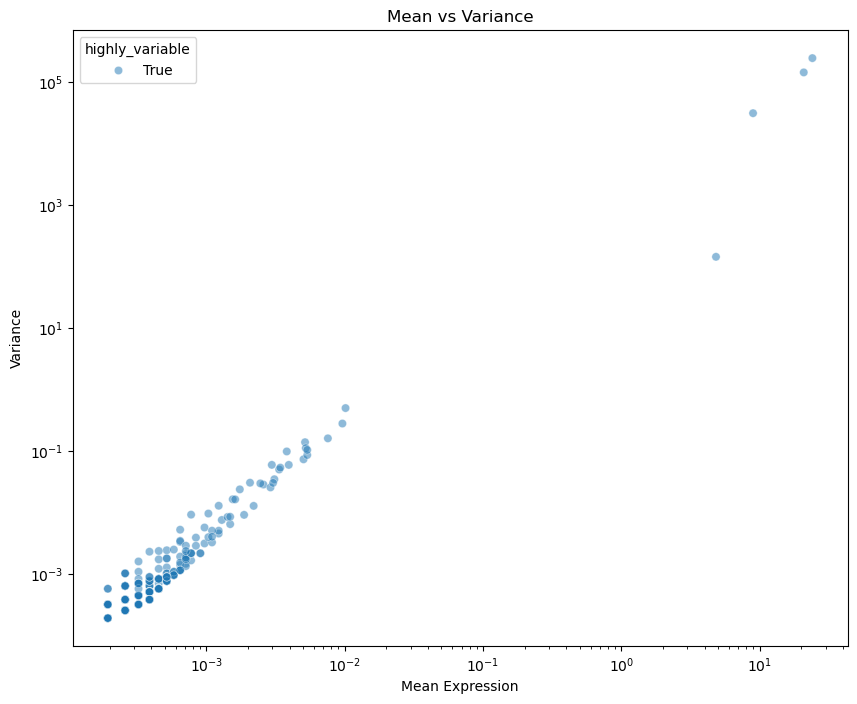

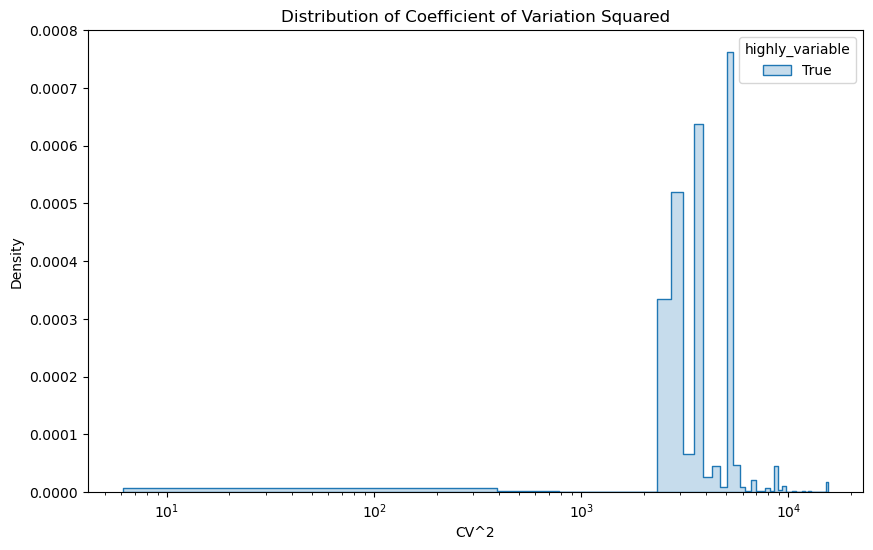

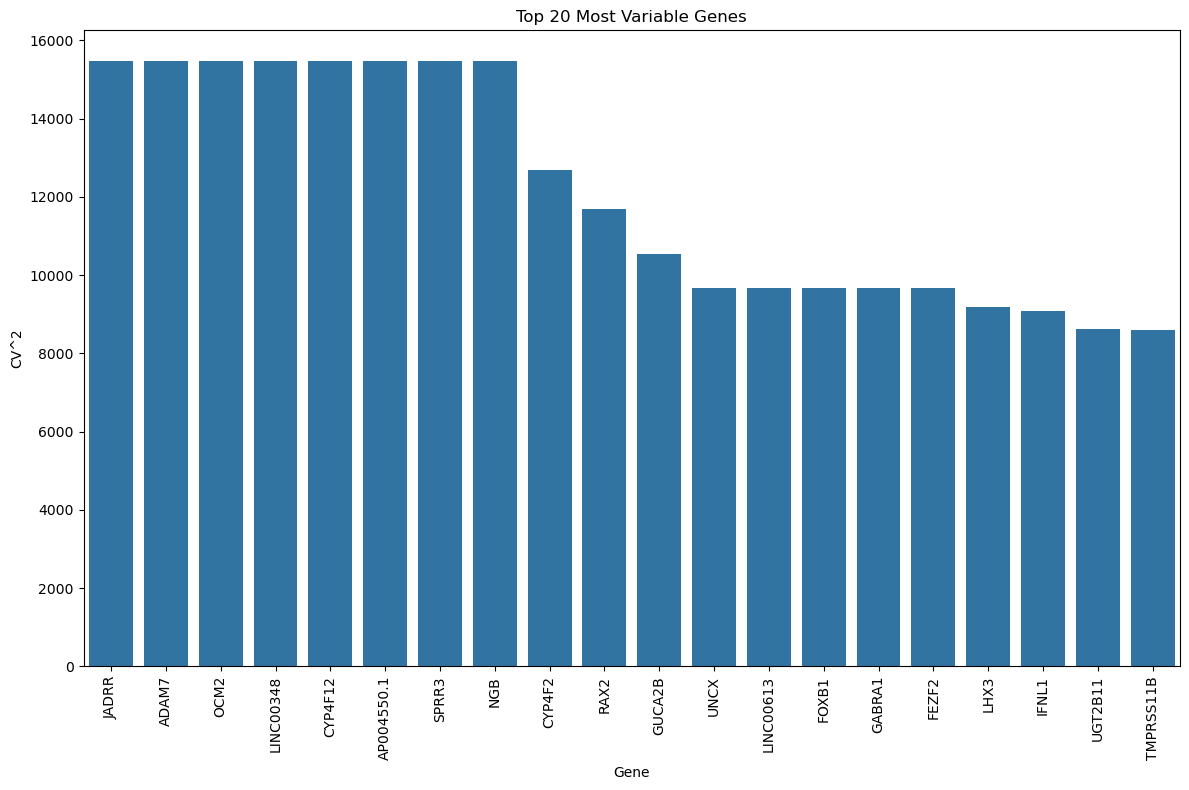

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que ya has ejecutado el código anterior y tienes el DataFrame gene_info

# 1. Scatter plot de media vs varianza
plt.figure(figsize=(10, 8))
sns.scatterplot(data=gene_info, x='mean', y='variance', hue='highly_variable', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Mean vs Variance')
plt.xlabel('Mean Expression')
plt.ylabel('Variance')
plt.show()

# 2. Distribución del coeficiente de variación al cuadrado
plt.figure(figsize=(10, 6))
sns.histplot(data=gene_info, x='cv_squared', hue='highly_variable', element='step', stat='density', common_norm=False)
plt.xscale('log')
plt.title('Distribution of Coefficient of Variation Squared')
plt.xlabel('CV^2')
plt.ylabel('Density')
plt.show()

# 3. Top 20 genes más variables
top_20_genes = gene_info_sorted.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_20_genes, x=top_20_genes.index, y='cv_squared')
plt.xticks(rotation=90)
plt.title('Top 20 Most Variable Genes')
plt.xlabel('Gene')
plt.ylabel('CV^2')
plt.tight_layout()
plt.show()

## Step 2: Retrieve scGPT's attention weights

### 2.1 Prepare model input

In [18]:
# Verificar si 'X_binned' existe en adata.layers
if 'X_binned' not in adata.layers:
    print("'X_binned' not found in adata.layers. Using 'X' instead.")
    input_layer_key = "X"
else:
    input_layer_key = "X_binned"

all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)

In [19]:
# Usar la columna 'gene_name' que has creado
genes = adata.var["gene_name"].tolist()
gene_ids = np.array([vocab[gene] if gene in vocab else vocab['<unk>'] for gene in genes], dtype=int)

batch_size = 16
tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=len(genes)+1,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)


In [20]:
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])

# Usar 'celltype' para las condiciones
condition_ids = np.array(adata.obs["celltype"].tolist())


### 2.1 Retrieve attention weights
Note that since the flash-attn package does not output attention scores, we manually calculate q @ k.T to extract the attention weights. Users may specify which layer to extract the attention weights from. In the manuscript, we used the attention weights from the last (12th) layer.

In [21]:
torch.cuda.empty_cache()
dict_sum_condition = {}

In [22]:
# Use this argument to specify which layer to extract the attention weights from
# Default to 11, extraction from the last (12th) layer. Note that index starts from 0
num_attn_layers = 11

print("Preparation for attention weight extraction completed.")
print(f"Number of genes: {len(genes)}")
print(f"Shape of all_counts: {all_counts.shape}")
print(f"Shape of all_gene_ids: {all_gene_ids.shape}")
print(f"Shape of all_values: {all_values.shape}")
print(f"Number of unique conditions: {len(np.unique(condition_ids))}")

Preparation for attention weight extraction completed.
Number of genes: 1204
Shape of all_counts: (15486, 1204)
Shape of all_gene_ids: torch.Size([15486, 1205])
Shape of all_values: torch.Size([15486, 1205])
Number of unique conditions: 2


In [23]:
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
    M = all_gene_ids.size(1)
    N = all_gene_ids.size(0)
    device = next(model.parameters()).device
    for i in tqdm(range(0, N, batch_size)):
        batch_size = min(batch_size, N - i)  # Asegurarse de que el último lote no exceda N
        outputs = np.zeros((batch_size, M, M), dtype=np.float32)
        # Replicate the operations in model forward pass
        src_embs = model.encoder(all_gene_ids[i : i + batch_size].to(device))
        val_embs = model.value_encoder(all_values[i : i + batch_size].to(device))
        total_embs = src_embs + val_embs
        
        # Check if 'bn' exists in the model
        if hasattr(model, 'bn'):
            total_embs = model.bn(total_embs.permute(0, 2, 1)).permute(0, 2, 1)
        
        # Send total_embs to attention layers for attention operations
        # Retrieve the output from second to last layer
        for layer in model.transformer_encoder.layers[:num_attn_layers]:
            total_embs = layer(total_embs, src_key_padding_mask=src_key_padding_mask[i : i + batch_size].to(device))
        
        # Send total_embs to the last layer in flash-attn
        qkv = model.transformer_encoder.layers[num_attn_layers].self_attn.Wqkv(total_embs)
        # Retrieve q, k, and v from flash-attn wrapper
        qkv = rearrange(qkv, 'b s (three h d) -> b s three h d', three=3, h=8)
        q = qkv[:, :, 0, :, :]
        k = qkv[:, :, 1, :, :]
        v = qkv[:, :, 2, :, :]
        
        # Calculate attention scores
        attn_scores = q.permute(0, 2, 1, 3) @ k.permute(0, 2, 3, 1)
        # Rank normalization by row
        attn_scores = attn_scores.reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = rank.reshape((-1, 8, M, M))/M
        # Rank normalization by column
        attn_scores = attn_scores.permute(0, 1, 3, 2).reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = (rank.reshape((-1, 8, M, M))/M).permute(0, 1, 3, 2)
        # Average 8 attention heads
        attn_scores = attn_scores.mean(1)
        
        outputs = attn_scores.detach().cpu().numpy()
        
        for index in range(batch_size):
            # Keep track of sum per condition
            c = condition_ids[i + index]
            if c not in dict_sum_condition:
                dict_sum_condition[c] = np.zeros((M, M), dtype=np.float32)
            dict_sum_condition[c] += outputs[index, :, :]

print("Attention weight extraction completed.")
print(f"Number of conditions: {len(dict_sum_condition)}")
for condition, attention_sum in dict_sum_condition.items():
    print(f"Condition: {condition}, Shape of attention sum: {attention_sum.shape}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 968/968 [01:49<00:00,  8.83it/s]

Attention weight extraction completed.
Number of conditions: 2
Condition: Fibroblast, Shape of attention sum: (1205, 1205)
Condition: Partial, Shape of attention sum: (1205, 1205)


In [24]:
# Imprimir la estructura del modelo
print("Model structure:")
print(model)
print("\nModel attributes:")
for attr in dir(model):
    if not attr.startswith("__"):
        print(attr)
print("\nTransformer encoder layers:")
for i, layer in enumerate(model.transformer_encoder.layers):
    print(f"Layer {i}:")
    print(layer)

Model structure:
TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): L

### 2.2 Average rank-normed attention weights by condition
In the previous step, we retrieve the attention weights for all cells and keep the running sum by condition (i.e., control, perturbed). We further calculate the mean here by dividing the number of cells per condition to obtain a gene * gene attention matrix for each condition.

In [25]:
groups = adata.obs.groupby('celltype').groups

In [26]:
dict_sum_condition_mean = dict_sum_condition.copy()
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition_mean[i]/len(groups[i])
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [27]:
print("Average attention weights calculated for each cell type.")
for celltype, attention_mean in dict_sum_condition_mean.items():
    print(f"Cell type: {celltype}, Shape of mean attention: {attention_mean.shape}")

Average attention weights calculated for each cell type.
Cell type: Fibroblast, Shape of mean attention: (1205, 1205)
Cell type: Partial, Shape of mean attention: (1205, 1205)


## Step 3: Perform most influenced gene selection

In the manuscript, we proposed 3 settings for the most influenced gene selection, namely *Control*, *Perturb*, and *Difference*. In this example, we focus on the *Difference* setting to explore how the gene-gene network changes after perturbation compared to control.

In [28]:
# Ajustar la normalización:


def get_topk_most_influenced_genes(topk, setting):
    attn_top_gene_dict = {}
    attn_top_scores_dict = {}
    celltypes = list(dict_sum_condition_mean.keys())
    if len(celltypes) != 2:
        raise ValueError("Expected exactly two cell types for comparison.")
    
    control = celltypes[0]  # Assuming Fibroblast is the first
    experiment = celltypes[1]  # Assuming Partial is the second
    
    control_attn = dict_sum_condition_mean[control]
    exp_attn = dict_sum_condition_mean[experiment]
    
    if setting == 'difference':
        a = exp_attn - control_attn
        a = a.sum(axis=1)  # Suma a lo largo de las filas
    elif setting == 'control':
        a = control_attn.sum(axis=1)
    elif setting == 'experiment':
        a = exp_attn.sum(axis=1)
    else:
        raise ValueError("Invalid setting. Choose 'difference', 'control', or 'experiment'.")
    
    # Usar np.argpartition en lugar de np.argsort para eficiencia
    diff_idx = np.argpartition(np.abs(a), -topk)[-topk:]
    diff_idx = diff_idx[np.argsort(np.abs(a[diff_idx]))[::-1]]  # Ordenar por magnitud
    scores = a[diff_idx]
    attn_top_genes = [genes[i] for i in diff_idx]
    
    key = f"{experiment}_vs_{control}"
    attn_top_gene_dict[key] = list(attn_top_genes)
    attn_top_scores_dict[key] = list(scores)
    
    return attn_top_gene_dict, attn_top_scores_dict

In [29]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [30]:
# Calculate top 20 most influenced genes
topk = 20
setting = 'difference'
attn_top_gene_dict_20, attn_top_scores_dict_20 = get_topk_most_influenced_genes(topk, setting)
key = list(attn_top_gene_dict_20.keys())[0]
print(f"Top 20 scores: {attn_top_scores_dict_20[key]}")
print(f"Top 20 genes: {attn_top_gene_dict_20[key]}")

Top 20 scores: [-5.5430098, 4.6646805, -3.067821, -2.3403516, -0.6950872, -0.6009966, -0.5637707, 0.5632753, -0.560226, -0.55035555, -0.54393584, -0.52834857, -0.5157219, -0.50996405, 0.5092176, -0.48227298, -0.48004243, -0.47797465, -0.47517478, -0.4571915]
Top 20 genes: ['AC138647.1', 'PSORS1C3', 'C9orf152', 'LAMP3', 'PSAPL1', 'LINC02357', 'PKIA-AS1', 'KLRC1', 'LINC01561', 'NLRC4', 'IQCJ', 'PWWP3B', 'LINC01907', 'ERI3-IT1', 'CHRM5', 'FFAR4', 'FOXD4L1', 'LINC02094', 'SLAMF7', 'SLC46A2']


<Figure size 3000x2400 with 0 Axes>

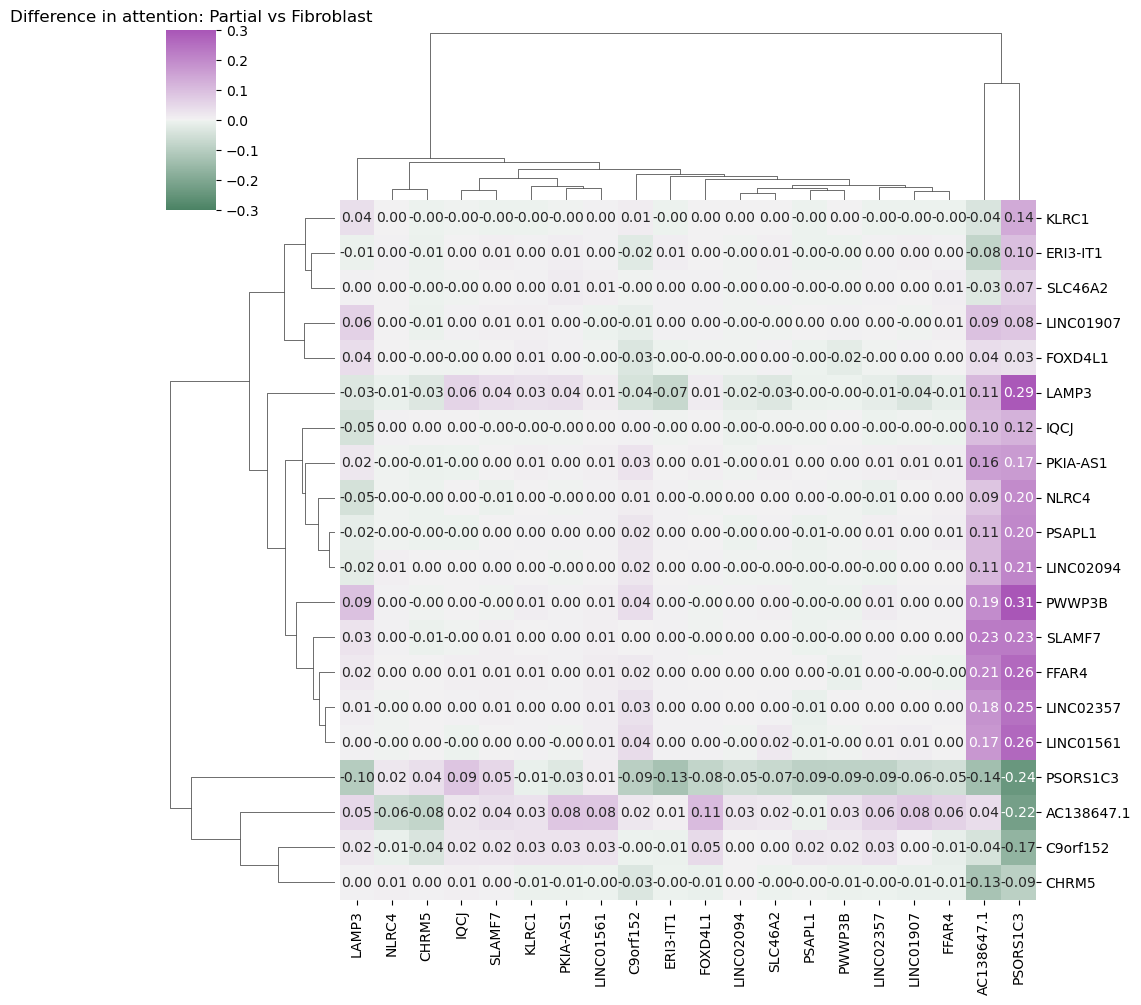

In [31]:
# Visualize the difference in attention for top 20 genes
if setting == 'difference':
    key = list(attn_top_gene_dict_20.keys())[0]
    example_genes = attn_top_gene_dict_20[key]
    
    # Definir 'experiment' y 'control'
    celltypes = list(dict_sum_condition_mean.keys())
    control = celltypes[0]  # Asumiendo que Fibroblast es el primero
    experiment = celltypes[1]  # Asumiendo que Partial es el segundo
    
    # Asegurarse de que 'genes' esté definido
    genes = adata.var_names.tolist()
    
    gene_idx = [genes.index(g) for g in example_genes]
    scores = dict_sum_condition_mean[experiment][gene_idx][:, gene_idx] - dict_sum_condition_mean[control][gene_idx][:, gene_idx]
    df_scores = pd.DataFrame(data=scores, columns=example_genes, index=example_genes)
    plt.figure(figsize=(10, 8), dpi=300)
    ax = sns.clustermap(df_scores, annot=True, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), fmt='.2f', vmin=-0.3, vmax=0.3)
    plt.title(f"Difference in attention: {experiment} vs {control}")
    plt.show()
    plt.close()

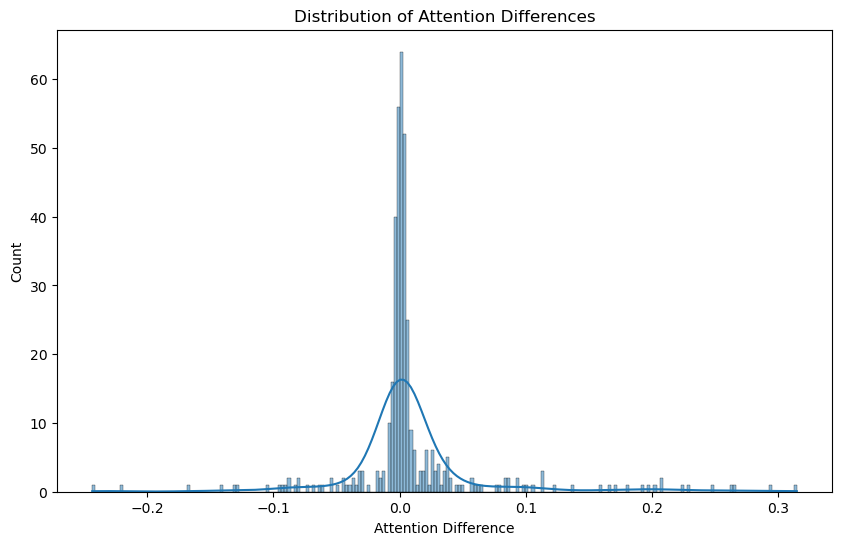

In [32]:
# Verificar la distribución de los datos:
# visualizamos la distribución de las diferencias de atención:
plt.figure(figsize=(10, 6))
sns.histplot(scores.flatten(), kde=True)
plt.title("Distribution of Attention Differences")
plt.xlabel("Attention Difference")
plt.show()

In [33]:
# Calculate top 100 most influenced genes for pathway validation
topk = 100
setting = 'difference'
attn_top_gene_dict_100, attn_top_scores_dict_100 = get_topk_most_influenced_genes(topk, setting)
key = list(attn_top_gene_dict_100.keys())[0]
print(f"Top 100 scores: {attn_top_scores_dict_100[key]}")
print(f"Top 100 genes: {attn_top_gene_dict_100[key]}")

Top 100 scores: [-5.5430098, 4.6646805, -3.067821, -2.3403516, -0.6950872, -0.6009966, -0.5637707, 0.5632753, -0.560226, -0.55035555, -0.54393584, -0.52834857, -0.5157219, -0.50996405, 0.5092176, -0.48227298, -0.48004243, -0.47797465, -0.47517478, -0.4571915, -0.45352164, 0.45300367, -0.45011288, 0.43252724, 0.4324467, -0.43001336, -0.4286553, -0.42486835, -0.42482203, -0.4078343, -0.405363, -0.4014246, -0.40038258, -0.39322564, -0.3904992, 0.38695368, -0.38583097, -0.3851929, -0.37890247, 0.37710407, 0.37082285, -0.36841345, -0.36815184, -0.368113, 0.36397132, -0.360277, 0.3592834, -0.35922426, 0.35620734, -0.35592455, 0.3546507, 0.34681866, -0.3454516, -0.33715463, -0.33623528, -0.33567637, -0.33452928, 0.33432436, 0.33430016, 0.3331086, 0.3326549, 0.3320577, -0.3309158, -0.3308245, -0.33022094, -0.33017385, -0.32840115, 0.3279451, 0.32362816, -0.32230514, 0.3209948, 0.32098183, -0.31984216, 0.3185622, 0.3180895, 0.31779277, 0.3164187, -0.31455094, -0.31441116, -0.3141557, 0.31258893

## Step 4: Validate most influenced genes

### Step 4.1: Pathway analysis with Reactome

In [34]:
# Enriquecimiento con Reactome
import pandas as pd
import gseapy as gp

# Definir la clave específica
key = 'Partial_vs_Fibroblast'  # Asegúrate de que esta clave esté en attn_top_gene_dict_100
gene_list = attn_top_gene_dict_100[key]

# Definir la base de datos para Reactome
databases = ['Reactome_2022']

# Realizar el análisis de enriquecimiento con Reactome
df_attn = pd.DataFrame()
enr_Reactome = gp.enrichr(gene_list=gene_list,
                          gene_sets=databases,
                          organism='Human', 
                          outdir=None,  # No guardar archivos temporalmente
                          cutoff=0.5)

# Filtrar resultados por p-value
p_thresh = 0.05 / (len(gene_list) * 1818)  # 1818 es el número de términos en Reactome según df_database
out = enr_Reactome.results
out['Gene List'] = str(gene_list)
df_attn = out[out['P-value'] < p_thresh]

# Imprimir los resultados del análisis
print(f"Number of enriched pathways: {len(df_attn)}")
if len(df_attn) > 0:
    print("\nTop 10 enriched pathways:")
    print(df_attn[['Term', 'P-value', 'Adjusted P-value']].head(10))
else:
    print("No se encontraron vías enriquecidas significativas.")
    print("\nTop 10 vías con los p-valores más bajos (aunque no significativos):")
    print(out[['Term', 'P-value', 'Adjusted P-value']].head(10))

# Guardar los resultados en un archivo CSV para análisis posterior
df_attn.to_csv('reactome_enrichment_results.csv', index=False)


Number of enriched pathways: 0
No se encontraron vías enriquecidas significativas.

Top 10 vías con los p-valores más bajos (aunque no significativos):
                                                Term   P-value  \
0  Immunoregulatory Interactions Between A Lympho...  0.003390   
1                       Glucuronidation R-HSA-156588  0.006889   
2                            Drug ADME R-HSA-9748784  0.012045   
3           Signaling By Retinoic Acid R-HSA-5362517  0.017880   
4  TP53 Regulates Transcription Of Cell Death Gen...  0.020429   
5                         Aspirin ADME R-HSA-9749641  0.020429   
6          G Alpha (Q) Signaling Events R-HSA-416476  0.021853   
7             Free Fatty Acid Receptors R-HSA-444209  0.024754   
8  Tachykinin Receptors Bind Tachykinins R-HSA-38...  0.024754   
9    Muscarinic Acetylcholine Receptors R-HSA-390648  0.024754   

   Adjusted P-value  
0           0.31437  
1           0.31437  
2           0.31437  
3           0.31437  
4          

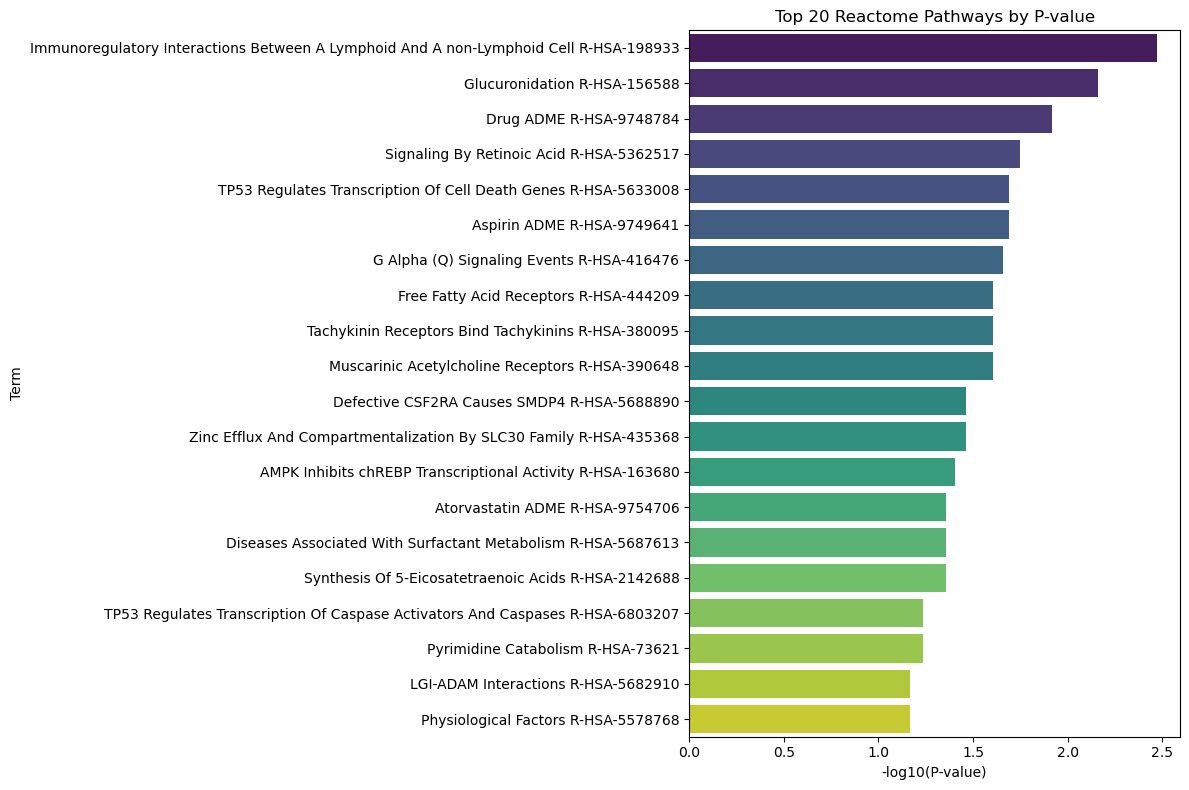

In [35]:
# Grafico Reactome
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarse de que 'out' contiene resultados
if not out.empty:
    # Seleccionar las 20 vías con los p-valores más bajos
    top_20 = out.sort_values(by='P-value').head(20)
    top_20['-log10(P-value)'] = -np.log10(top_20['P-value'])

    # Crear el gráfico de barras
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_20, y='Term', x='-log10(P-value)', palette='viridis')
    plt.title('Top 20 Reactome Pathways by P-value')
    plt.xlabel('-log10(P-value)')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos para mostrar en el gráfico.")


In [36]:
# Enriquecimeinto con GO
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns

# Definir la clave específica
key = 'Partial_vs_Fibroblast'  # Asegúrate de que esta clave esté en attn_top_gene_dict_100
gene_list = attn_top_gene_dict_100[key]

# Lista de bases de datos centrada solo en GO
databases = ['GO_Biological_Process_2021']

# Ejecutar Enrichr para la base de datos seleccionada
all_enriched_terms = pd.DataFrame()

for db in databases:
    print(f"Procesando la base de datos: {db}")
    enr = gp.enrichr(gene_list=gene_list,
                     gene_sets=db,
                     organism='Human', 
                     outdir=None,  # No guardar archivos temporalmente
                     cutoff=0.05)  # Puedes ajustar este valor según sea necesario
    
    if not enr.results.empty:
        enriched_terms = enr.results
        # Considerar todos los términos con p-valor bajo y listar los que podrían ser relevantes
        enriched_terms['-log10(P-value)'] = -np.log10(enriched_terms['P-value'])
        all_enriched_terms = pd.concat([all_enriched_terms, enriched_terms], ignore_index=True)
        
        if not enriched_terms[enriched_terms['Adjusted P-value'] < 0.05].empty:
            print(f"Resultados de enriquecimiento significativos en {db}:")
            print(enriched_terms[enriched_terms['Adjusted P-value'] < 0.05][['Term', 'P-value', 'Adjusted P-value']])
        else:
            print(f"No se encontraron términos enriquecidos significativos para {db}")
        
        # Mostrar también términos con P-valores bajos pero no significativos después de la corrección
        print(f"Términos con P-valores bajos en {db}:")
        print(enriched_terms[['Term', 'P-value', 'Adjusted P-value']].head(10))
    else:
        print(f"No se encontraron términos enriquecidos para {db}")

# Guardar resultados en un archivo CSV para análisis posterior
all_enriched_terms.to_csv('go_enrichment_analysis_results.csv', index=False)



Procesando la base de datos: GO_Biological_Process_2021
No se encontraron términos enriquecidos significativos para GO_Biological_Process_2021
Términos con P-valores bajos en GO_Biological_Process_2021:
                                                Term   P-value  \
0  negative regulation of intracellular transport...  0.000511   
1        brown fat cell differentiation (GO:0050873)  0.000680   
2  negative regulation of heterotypic cell-cell a...  0.001085   
3  regulation of cell-cell adhesion involved in g...  0.001085   
4            xenobiotic glucuronidation (GO:0052697)  0.001322   
5  positive regulation of transporter activity (G...  0.001862   
6              cellular glucuronidation (GO:0052695)  0.004004   
7  negative regulation of response to wounding (G...  0.004885   
8  positive regulation of cholesterol efflux (GO:...  0.005848   
9                    response to hexose (GO:0009746)  0.006889   

   Adjusted P-value  
0          0.140379  
1          0.140379  
2   

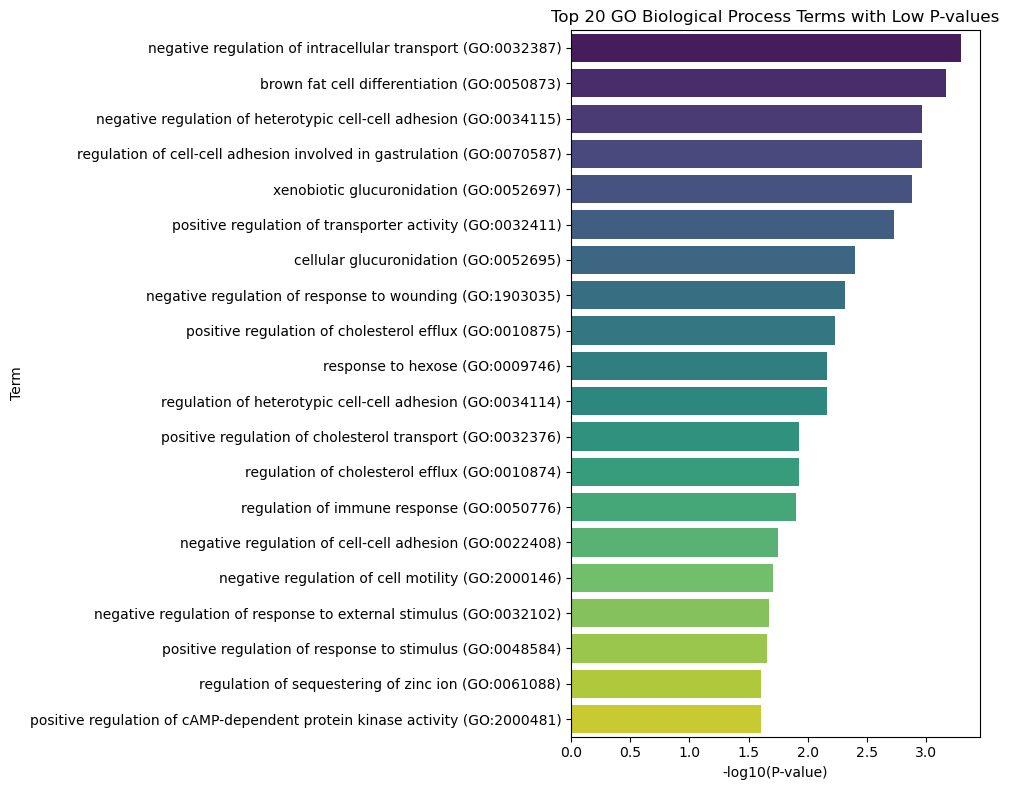

                       Gene_set  \
0    GO_Biological_Process_2021   
1    GO_Biological_Process_2021   
2    GO_Biological_Process_2021   
3    GO_Biological_Process_2021   
4    GO_Biological_Process_2021   
..                          ...   
526  GO_Biological_Process_2021   
527  GO_Biological_Process_2021   
528  GO_Biological_Process_2021   
529  GO_Biological_Process_2021   
530  GO_Biological_Process_2021   

                                                  Term Overlap   P-value  \
0    negative regulation of intracellular transport...     2/7  0.000511   
1          brown fat cell differentiation (GO:0050873)     2/8  0.000680   
2    negative regulation of heterotypic cell-cell a...    2/10  0.001085   
3    regulation of cell-cell adhesion involved in g...    2/10  0.001085   
4              xenobiotic glucuronidation (GO:0052697)    2/11  0.001322   
..                                                 ...     ...       ...   
526              neutrophil degranulation (GO:0

In [37]:
# Grafico GO
top_terms = all_enriched_terms.head(20)  # Mostrar los primeros 20 términos como ejemplo

plt.figure(figsize=(10, 8))
sns.barplot(data=top_terms, y='Term', x='-log10(P-value)', palette='viridis')
plt.title('Top 20 GO Biological Process Terms with Low P-values')
plt.xlabel('-log10(P-value)')
plt.tight_layout()
plt.show()

# Imprimir todos los resultados
print(all_enriched_terms)


Procesando la base de datos: GO_Biological_Process_2021
No se encontraron términos enriquecidos significativos para GO_Biological_Process_2021
Términos con P-valores bajos en GO_Biological_Process_2021:
                                                Term   P-value  \
0  negative regulation of intracellular transport...  0.000511   
1        brown fat cell differentiation (GO:0050873)  0.000680   
2  negative regulation of heterotypic cell-cell a...  0.001085   
3  regulation of cell-cell adhesion involved in g...  0.001085   
4            xenobiotic glucuronidation (GO:0052697)  0.001322   
5  positive regulation of transporter activity (G...  0.001862   
6              cellular glucuronidation (GO:0052695)  0.004004   
7  negative regulation of response to wounding (G...  0.004885   
8  positive regulation of cholesterol efflux (GO:...  0.005848   
9                    response to hexose (GO:0009746)  0.006889   

   Adjusted P-value  
0          0.140379  
1          0.140379  
2   

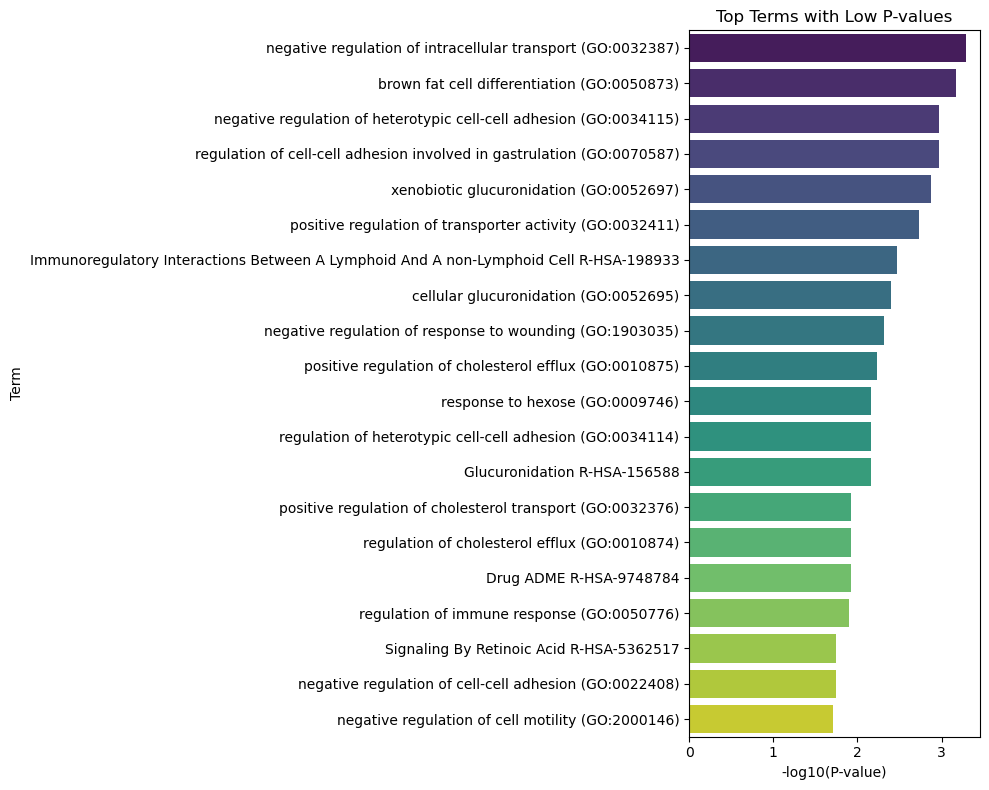

In [38]:
# Enriquecimiento en GO y Reactome y gráfico conjunto de vías.
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns

# Define las bases de datos a usar
databases = ['GO_Biological_Process_2021', 'Reactome_2022']

# Ejecutar Enrichr para cada base de datos seleccionada
all_enriched_terms = pd.DataFrame()

for db in databases:
    print(f"Procesando la base de datos: {db}")
    enr = gp.enrichr(gene_list=gene_list,
                     gene_sets=db,
                     organism='Human', 
                     outdir=None,  # No guardar archivos temporalmente
                     cutoff=0.05)  # Umbral de corte
    
    if not enr.results.empty:
        enriched_terms = enr.results
        enriched_terms['-log10(P-value)'] = -np.log10(enriched_terms['P-value'])
        all_enriched_terms = pd.concat([all_enriched_terms, enriched_terms], ignore_index=True)

        significant_terms = enriched_terms[enriched_terms['Adjusted P-value'] < 0.05]
        if not significant_terms.empty:
            print(f"Resultados de enriquecimiento significativos en {db}:")
            print(significant_terms[['Term', 'P-value', 'Adjusted P-value']])
        else:
            print(f"No se encontraron términos enriquecidos significativos para {db}")

        print(f"Términos con P-valores bajos en {db}:")
        print(enriched_terms[['Term', 'P-value', 'Adjusted P-value']].head(10))
    else:
        print(f"No se encontraron términos enriquecidos para {db}")

# Guardar todos los resultados en un archivo CSV para análisis posterior
all_enriched_terms.to_csv('enrichment_analysis_results.csv', index=False)

# Visualizar los términos con p-valores más bajos
if not all_enriched_terms.empty:
    plt.figure(figsize=(10, 8))
    top_terms = all_enriched_terms.sort_values(by='P-value').head(20)
    sns.barplot(data=top_terms, y='Term', x='-log10(P-value)', palette='viridis')
    plt.title('Top Terms with Low P-values')
    plt.xlabel('-log10(P-value)')
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron términos con p-valores bajos.")


Procesando la base de datos: GO_Biological_Process_2021
No se encontraron términos enriquecidos significativos para GO_Biological_Process_2021
Términos con P-valores bajos en GO_Biological_Process_2021:
                                                Term   P-value  \
0  negative regulation of intracellular transport...  0.000511   
1        brown fat cell differentiation (GO:0050873)  0.000680   
2  negative regulation of heterotypic cell-cell a...  0.001085   
3  regulation of cell-cell adhesion involved in g...  0.001085   
4            xenobiotic glucuronidation (GO:0052697)  0.001322   
5  positive regulation of transporter activity (G...  0.001862   
6              cellular glucuronidation (GO:0052695)  0.004004   
7  negative regulation of response to wounding (G...  0.004885   
8  positive regulation of cholesterol efflux (GO:...  0.005848   
9                    response to hexose (GO:0009746)  0.006889   

   Adjusted P-value  
0          0.140379  
1          0.140379  
2   

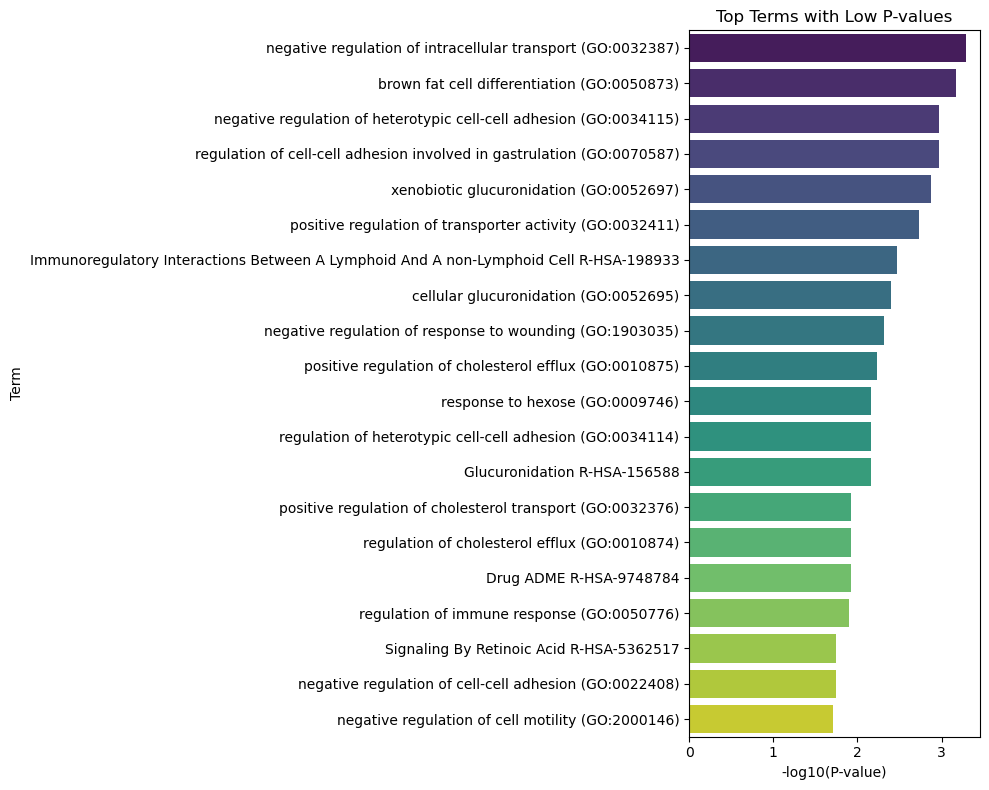

In [39]:
# lo mismo que la celda anterior, reactome y go pero con clave partial y fibroblast en vez de 100 genes, creo que es lo mism oen realidad
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns

# Definir la clave específica
key = 'Partial_vs_Fibroblast'  # Especificar la clave correcta
gene_list = attn_top_gene_dict_100[key]

# Define las bases de datos a usar
databases = ['GO_Biological_Process_2021', 'Reactome_2022']

# Ejecutar Enrichr para cada base de datos seleccionada
all_enriched_terms = pd.DataFrame()

for db in databases:
    print(f"Procesando la base de datos: {db}")
    enr = gp.enrichr(gene_list=gene_list,
                     gene_sets=db,
                     organism='Human', 
                     outdir=None,  # No guardar archivos temporalmente
                     cutoff=0.05)  # Umbral de corte
    
    if not enr.results.empty:
        enriched_terms = enr.results
        enriched_terms['-log10(P-value)'] = -np.log10(enriched_terms['P-value'])
        all_enriched_terms = pd.concat([all_enriched_terms, enriched_terms], ignore_index=True)

        significant_terms = enriched_terms[enriched_terms['Adjusted P-value'] < 0.05]
        if not significant_terms.empty:
            print(f"Resultados de enriquecimiento significativos en {db}:")
            print(significant_terms[['Term', 'P-value', 'Adjusted P-value']])
        else:
            print(f"No se encontraron términos enriquecidos significativos para {db}")

        print(f"Términos con P-valores bajos en {db}:")
        print(enriched_terms[['Term', 'P-value', 'Adjusted P-value']].head(10))
    else:
        print(f"No se encontraron términos enriquecidos para {db}")

# Guardar todos los resultados en un archivo CSV para análisis posterior
all_enriched_terms.to_csv('enrichment_analysis_results.csv', index=False)

# Visualizar los términos con p-valores más bajos
if not all_enriched_terms.empty:
    plt.figure(figsize=(10, 8))
    top_terms = all_enriched_terms.sort_values(by='P-value').head(20)
    sns.barplot(data=top_terms, y='Term', x='-log10(P-value)', palette='viridis')
    plt.title('Top Terms with Low P-values')
    plt.xlabel('-log10(P-value)')
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron términos con p-valores bajos.")
